$\newcommand{\myvector}[2]{\left\{ \begin{array}{c}#1\\#2\end{array} \right\}}$
$\newcommand{\sM}[1]{s_{\mathrm{M#1}}}$
$\newcommand{\xM}[1]{x_{\mathrm{M#1}}}$
$\newcommand{\xpM}[1]{x'_{\mathrm{M#1}}}$

# APPENDIX C:  Bayesian inverse kinematics basics


This Appendix describes a simple Bayesian inverse kinematics (IK) model to introduce the computational details of the main manuscript's Bayesian IK model.

Consider the slider mechanism pictured below.  This mechanism consists of a single rigid slider which moves to a global position $x$, and to which two markers ("M1" and "M2") are rigidly fixed.  Let's assume that we know that the marker positions relative to the slider's left edge are: $\sM{1}$ = 35 mm and $\sM{2}$ = 45 mm.

<img src="figs/slider.png" width="400">

Let's also assume that we have imperfectly measured the global marker positions ($\xpM{1}$ and $\xpM{2}$) as 46.0 and 55.0 mm, respectively. The IK problem is to find the slider position $x$ given the marker measurements $\xpM{1}$ and $\xpM{2}$.

### Approach 1: Least-squares

The true global marker positions can be expressed in terms of our unknown variable $x$ as follows:

\begin{align}
\xM{1} &= x + 35 \ \ \ \ \ \ \ \ \ \ \ \rm{(Equation \ 1)} \\
\xM{2} &= x + 45\\
\end{align}

The sum of the squared measurement errors is:

\begin{equation}
f(x) = (\xM{1} - 46)^2 + (\xM{2} - 55)^2
\end{equation}

which reduces to:

\begin{align}
f(x)   &= (x + 35 - 46)^2 + (x + 45 - 55)^2 \\
       &= (x - 11)^2 + (x - 10)^2 \\
       &= (x^2 -22x + 121) + (x^2 - 20x + 100)\\
       &= 2x^2 -42x + 221
\end{align}

The minimum value of this function is the least-squares (LS) solution, and is given when the derivative is zero:

\begin{align}
\frac{d}{dx}f(x) &= 4x - 42 = 0\\
x &= \frac{42}{4}
\end{align}

so our least-squares estimate is: $x$ = 10.5 mm, and the LS-minimized measurement error is 0.5 mm for each marker.

### Approach 2:  Bayesian

In contrast to the least-squares (LS) approach, which minimizes measurement error, **the Bayesian approach maximizes model parameters' mean posterior probabilities** given observed (noisy) data. A roughly equivalent interpretation is that the Bayesian approach maximizes the probability of observing the given data. This is done by optimizing the parameters which characterize a stochastic system.

To implement Bayesian IK we start with a model of our measurements as depicted below.


<img src="figs/bikmodel1.png" width="300">


This is a diagram which illustrates what we know, what we don't know, and what we measure.

- We don't know the true slider position $x$, so $x$ is modeled as a **stochastic variable**. Like in Appendix A and Appendix B, our pre-measurement beliefs regarding the true slider position can be modeled using a prior distribution, as detailed below.

- We also don't know the true positions of the two markers ($\xM{1}$ and $\xM{2}$). However, these positions will become known once the slider moves to a certain position $x$.  In other words, setting the slider position determines the marker positions, so the marker positions are **deterministic variables**.

- We know the measured marker positions ($\boldsymbol{q}$). Bayesian inference should treat these positions as **measured variables**.

- We know that marker measurements generally contain error ($\boldsymbol{\epsilon}$), but we don't yet know exactly what the error is for each marker.  Like the slider position $x$, $\boldsymbol{\epsilon}$ can also generaly be treated as a stochastic variable. In some cases we know the measurement error, based on manufacturer specifications and/or based on experiments, so the error amplitude ($\boldsymbol{\epsilon}$) can instead be treated as a constant value. The diagram above depicts $\boldsymbol{\epsilon}$ as a stochastic variable simply because it is more general to model the data this way, and Bayesian inference can easily and simultaneously estimate the most likely values for both $x$ and $\boldsymbol{\epsilon}$.

Here the overall goal of Bayesian inference is to estimate the most likely values of both $x$ and $\boldsymbol{\epsilon}$, given the marker measurements and given our measurements model (Equation 1). More specifically, Bayesian inference will mutually maximize the maxima of the posterior distributions for $x$ and $\boldsymbol{\epsilon}$, and from these posteriors we can extract the most likely values for $x$ and $\boldsymbol{\epsilon}$.

Let's start to implement this Bayesian model in Python by defining known values:  the true local positions and the observed measurement values.

In [1]:
%matplotlib notebook

import numpy as np
from matplotlib import pyplot

### local positions:
sM1 = 35.0
sM2 = 45.0
### measurements:
xpM1 = 46.0
xpM2 = 55.0

Let's next implement a function which will generate random datasets $\boldsymbol{q}$ according to our measurement model. Let's arbitrarily set the current slider position to $x$ = 8 mm, and let's assume that our measurement error $\boldsymbol{\epsilon}$ is Gaussian with a standard deviation of 0.5 mm.

In [2]:
import random

noise_sd = 0.5  #mm

#define measurement model:
def random_measurement(x):
    xM1 = x + sM1 + random.gauss(0, noise_sd)
    xM2 = x + sM2 + random.gauss(0, noise_sd)
    return [xM1, xM2]

#generate random data (20 observations):
random.seed(0)
x = 8.0
X = np.array([random_measurement(x)  for i in range(20)])
print( X )

[[ 43.4708577   52.30171095]
 [ 42.66014278  53.18525178]
 [ 42.49182555  52.96393999]
 [ 43.08959824  52.58445039]
 [ 42.34548132  53.09694387]
 [ 43.49662485  52.67650918]
 [ 42.83316601  53.82283588]
 [ 42.72055512  52.74292167]
 [ 44.20205967  52.2344587 ]
 [ 43.39823292  51.99817574]
 [ 42.70151863  53.75184044]
 [ 43.61071821  52.54943992]
 [ 42.77315063  53.04011652]
 [ 42.37094835  53.27611   ]
 [ 44.11378865  52.32237925]
 [ 42.00923346  53.14412187]
 [ 42.94043834  53.90216497]
 [ 42.91981891  52.97467014]
 [ 42.90456306  52.50469688]
 [ 43.33651499  52.33795877]]


This represents 20 different sets of measurements we could expect if our model is accurate. The results can be visualized as follows:

<IPython.core.display.Javascript object>


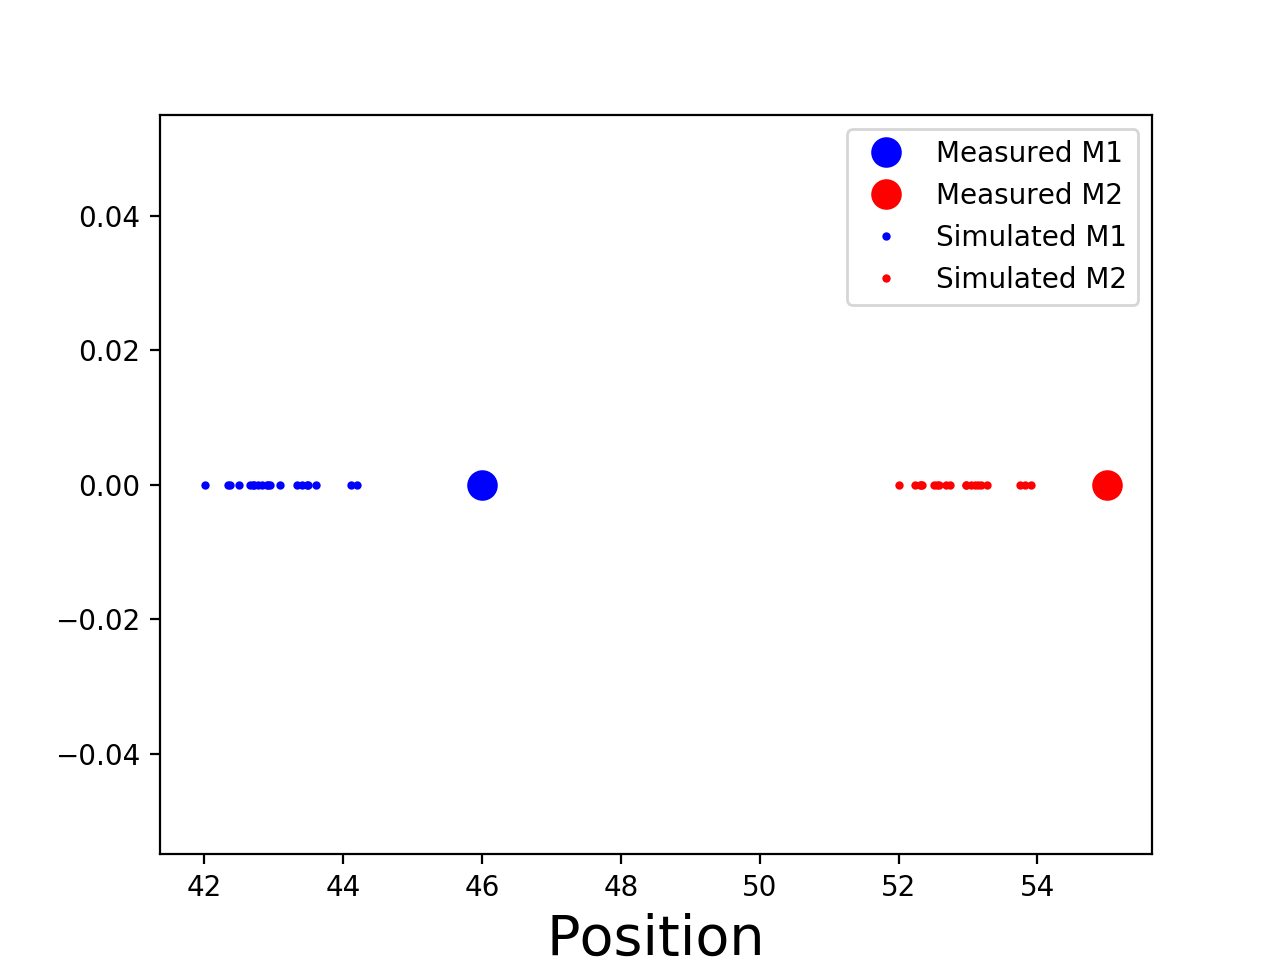

In [3]:
def myplot(X):
    ax = pyplot.axes()
    ax.plot(xpM1, 0, 'bo', markersize=10, label='Measured M1')
    ax.plot(xpM2, 0, 'ro', markersize=10, label='Measured M2')
    ax.plot(X[:,0], [0]*X.shape[0], 'b.', markersize=4, label='Simulated M1')
    ax.plot(X[:,1], [0]*X.shape[0], 'r.', markersize=4, label='Simulated M2')
    ax.legend()
    ax.set_xlabel('Position', size=20)
    
pyplot.figure()
myplot(X)

For the current position ($x$=8) and assumed measurement error ($\epsilon$=0.5) the simulated data do not overlap with the measured data, implying that the current value of $x$ is unlikely to have produced the observed (measured) data. Let's change $x$ to 10 and try again.

<IPython.core.display.Javascript object>


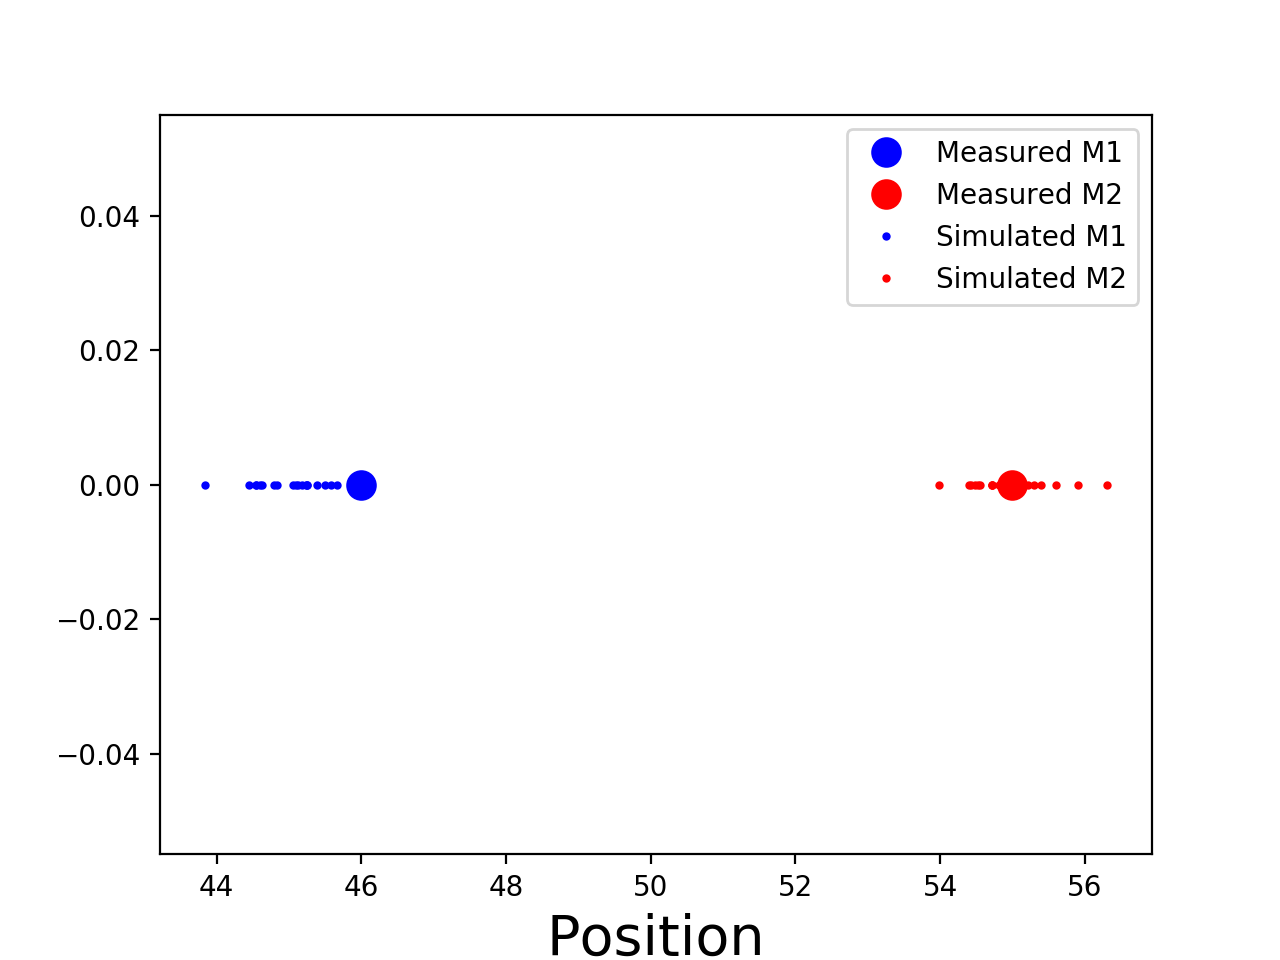

In [4]:
X = np.array([random_measurement(10)  for i in range(20)])
pyplot.figure()
myplot(X)

There is now much greater overlap between the simulated and measured data, implying that $x$=10 is more likely to have produced the observed data than $x$=8. To find the optimum value for $x$ using Bayesian inference, let's first implement our observations model in PyMC.

In [5]:
import pymc

tau = 1 / 0.5**2    #measurement precision ( 1 / SD^2 )
x   = pymc.Uniform("x", -20, 20)  #prior distribution for x

@pymc.deterministic
def observations_model(x=x):
    xM1 = x + sM1  #global position of Marker 1
    xM2 = x + sM2  #global position of Marker 2
    return [xM1, xM2]
q = pymc.Normal("q", observations_model, tau)

In the code snippet above a variable "`tau`" is created to specify our assumed measurement precision, where precision ($\tau$) is defined as the inverse of variance ($\sigma^2$):

\begin{equation}
\tau \equiv \dfrac{1}{\sigma^2}
\end{equation}

Since we have assumed a standard deviation of 0.5 mm, our assumed precision is: $\tau$=4. 

Next we specify a prior distribution for the slider position $x$. The prior distribution used above is uniform between $x=-20$ and $x=+20$, implying that the slider can be anywhere in that range with equal probability. Note that the variable "`x`" is a stochastic PyMC variable.  This means that we can generate random values for this variable based on its current distribution as follows:

In [6]:
print( x.random() )
print( x.random() )
print( x.random() )
print( x.random() )
print( x.random() )

-11.315754709950458
7.105600574322246
-11.94659527862421
-11.516805732079959
15.236101916711526


You can see that these random values span the range [-20, 20]. Every time we call `random()`, PyMC changes `x`'s  "`value`" attribute as follows.

In [7]:
print( x.value )  #the final value from above
print( x.value )  #the value hasn't changed yet
x.random()
print( x.value )  #now it has

15.236101916711526
15.236101916711526
4.087767389281446


The last step in the code snippet above is to create a PyMC observations model. First we create a function called `observations_model` which computes the expected marker positions based on the value of `x` and returns both values.  Next we tell PyMC that the result of `observations_model` should be regarded as stochastic, with a normal (Gaussian) distribution that has a mean of the true marker positions (given `x`) and a precision of `tau`.  The "`@pymc.deterministic`" statement is a function decorator which alerts PyMC to regard this function as a deterministic variable, and to use `x`'s value inside that function. Just like `x`, `q` is now a PyMC stochastic variable and we can generate random `q` values as follows.


In [8]:
x.set_value(0)      #set the slider position
print( q.random() ) #random marker positions given x=0
print( q.random() ) 
print( q.random() ) 
print( q.random() ) 
print( q.random() ) 

[ 34.85133707  45.18584781]
[ 35.65154373  44.95182808]
[ 34.3090463  44.7054686]
[ 35.29373893  45.08080711]
[ 34.2352072   45.66026864]


If we instead choose the least-squares solution $x=10.5$ we can generate random data which looks much more like our observed values of:  $\xpM{1}=46$ and $\xpM{2}=55$. 

In [9]:
x.set_value(10.5)
print( q.random() )
print( q.random() ) 
print( q.random() ) 
print( q.random() ) 
print( q.random() ) 

[ 45.97886828  55.90633564]
[ 45.0061945   55.79180418]
[ 44.88987861  55.76826227]
[ 45.10581923  55.49284068]
[ 45.92758787  55.22932364]


Instead of directly altering $x$ in this manner, and then finding its optimal value in a numerical optimization sense, PyMC instead uses the observed data to alter $x$'s current distribution, and then examine $x$'s and $q$'s posterior distributions in attempts to maximize their maxima.  In other words, rather than searching for a single optimum value for $x$, PyMC recognizes that both $x$ and $q$ are probabilistic, so attempts to mutually maximize their posterior probabilities, given the observed data.  In order to achieve that we first have to tell PyMC what our observations were. This can be done by slightly altering our $q$ variable as follows:

In [10]:
qobs = pymc.Normal("qobs", observations_model, tau, value=[46,55], observed=True)

Next, maximizing the posterior distributions can be achieved with a Markov Chain Monte Carlo (MCMC) simulation:

In [11]:
mcmc = pymc.MCMC([qobs, x])
mcmc.sample(40000, 20000)

 [-----------------100%-----------------] 40000 of 40000 complete in 1.0 sec

The first line initializes a model for MCMC simulation using all stochastic variables. The second line iteratively samples from their posterior distributions, discarding the first 20,000 iterations, and retaining the final 20,000 iterations for the final posterior distributions.  Let's examine our posterior distribution for $x$.

<IPython.core.display.Javascript object>


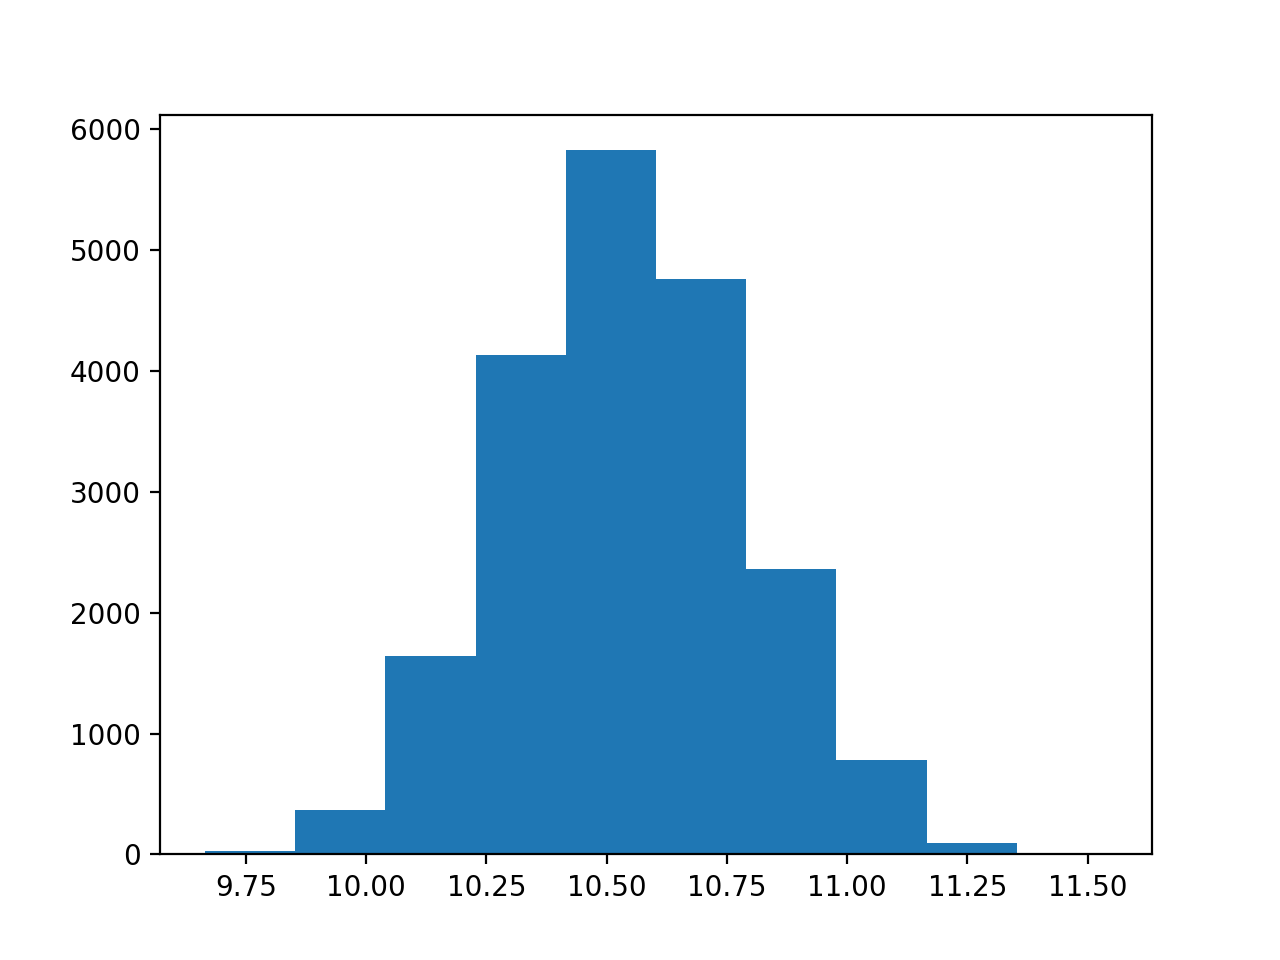

In [12]:
X = mcmc.trace('x')[:]
pyplot.figure()
pyplot.hist(X);

This posterior distribution spans the least-squares solution ($x$=10.5), and the maximum a posteriori likelihood (MAP) is very close to the least-square solution:

In [13]:
print( X.mean() )  #MAP

10.5414669957


However, as depicted in the posterior distribution above there is also a fair bit of uncertainty in our estimate for $x$. Surely values of $x$=10 or $x$=11.0 aren't the best choices, but this result suggests that they are still plausible, based on our modeling assumptions.  So let's change the assumptions and examine the effects. Let's first try increasing the presumed measurement precision (from SD=0.5 mm to SD=0.1 mm).

 [-----------------100%-----------------] 40000 of 40000 complete in 0.9 sec

<IPython.core.display.Javascript object>


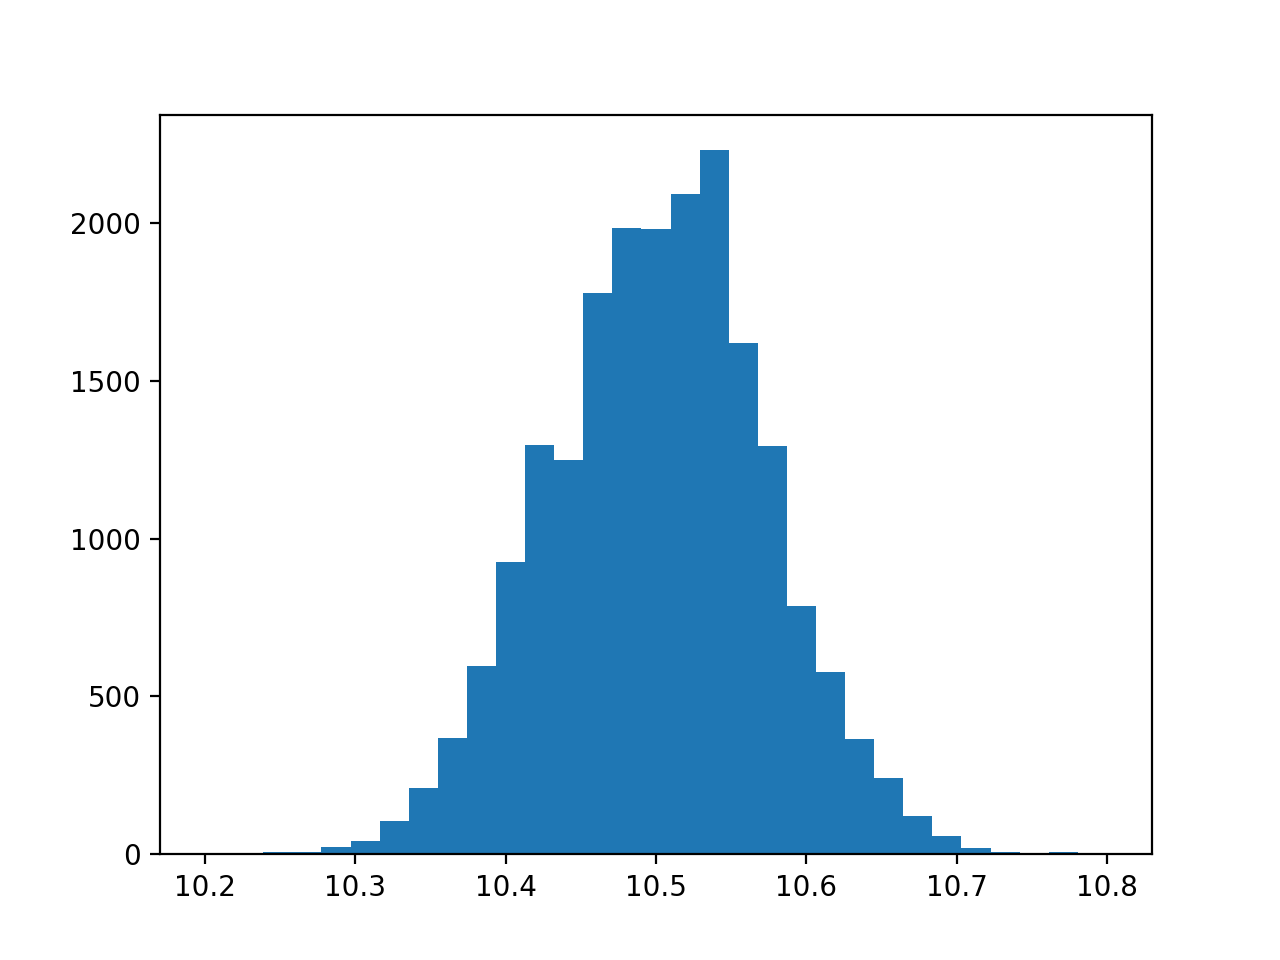

In [14]:
tau  = 1 / 0.1**2    #measurement precision ( 1 / SD^2 )
x    = pymc.Uniform("x", -20, 20)  #prior distribution for x
@pymc.deterministic
def observations_model(x=x):
    xM1 = x + sM1  #global position of Marker 1
    xM2 = x + sM2  #global position of Marker 2
    return [xM1, xM2]
qobs = pymc.Normal("qobs", observations_model, tau, value=[46,55], observed=True)

mcmc = pymc.MCMC([qobs, x])
mcmc.sample(40000, 20000)

pyplot.figure()
X = mcmc.trace('x')[:]
pyplot.hist(X, range=(10.2,10.8), bins=31);

Greater assumed measurement precision has narrowed the posterior. Let's next try a presumption of extremely precise measurements (SD=0.01 mm).

 [-----------------100%-----------------] 40000 of 40000 complete in 0.9 sec

<IPython.core.display.Javascript object>


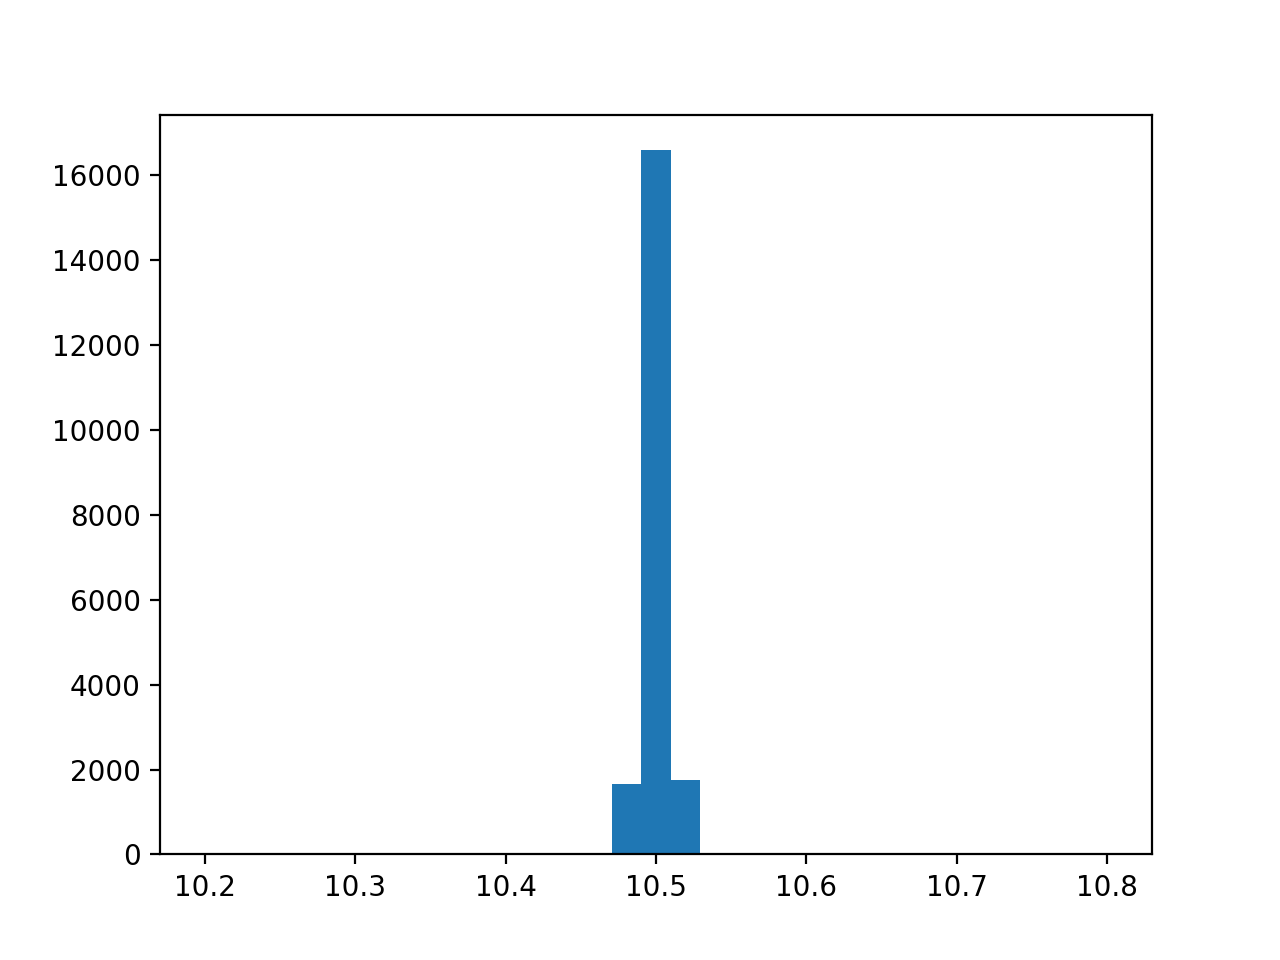

In [15]:
tau  = 1 / 0.01**2    #measurement precision ( 1 / SD^2 )
x    = pymc.Uniform("x", -20, 20)  #prior distribution for x
@pymc.deterministic
def observations_model(x=x):
    xM1 = x + sM1  #global position of Marker 1
    xM2 = x + sM2  #global position of Marker 2
    return [xM1, xM2]
qobs = pymc.Normal("qobs", observations_model, tau, value=[46,55], observed=True)

mcmc = pymc.MCMC([qobs, x])
mcmc.sample(40000, 20000)

pyplot.figure()
X = mcmc.trace('x')[:]
pyplot.hist(X, range=(10.2,10.8), bins=31);

Clearly our assumptions regarding $\tau$ have affected our posterior distribution.  In fact, it has become clear that **the least-squares solution is equivalent to the Bayesian solution under an assumption of infinite measurement precision**.  An equivalent interpretation is that as the presumed measurement precision increases, the Bayesian solution converges to $x$=10.5, with no uncertainty, just like the least-squares solution.

This seems somewhat strange:  the least-squares solution has minimized measurement error, so how can that be equivalent to an assumption of no measurement error?  This apparent paradox is resolved by the opposite perspectives on measurements that the two approaches adopt.  The least-squares approach regards the measured data as hard, and minimizes an explicit function of those measurements.  Contrastingly, the Bayesian approach regards the measured data as soft -- just one manifestation of an infinite set of plausible measurements.  Thus setting infinite precision forces the Bayesian approach to regard the data as hard, and consequently to assume zero variability in its estimate of $x$.

This raises an important point:  what actual value of precision should we use?  Most measurement device manufacturers provide technical specifications regarding measurement accuracy values, so one option is to use those precision data. A second, more Bayesian option, is to regard precision itself as stochastic, and to then let Bayesian inference decide the most likely precision, based on the data.  This can be implemented as follows:

 [-----------------100%-----------------] 40000 of 40000 complete in 1.4 sec

<IPython.core.display.Javascript object>


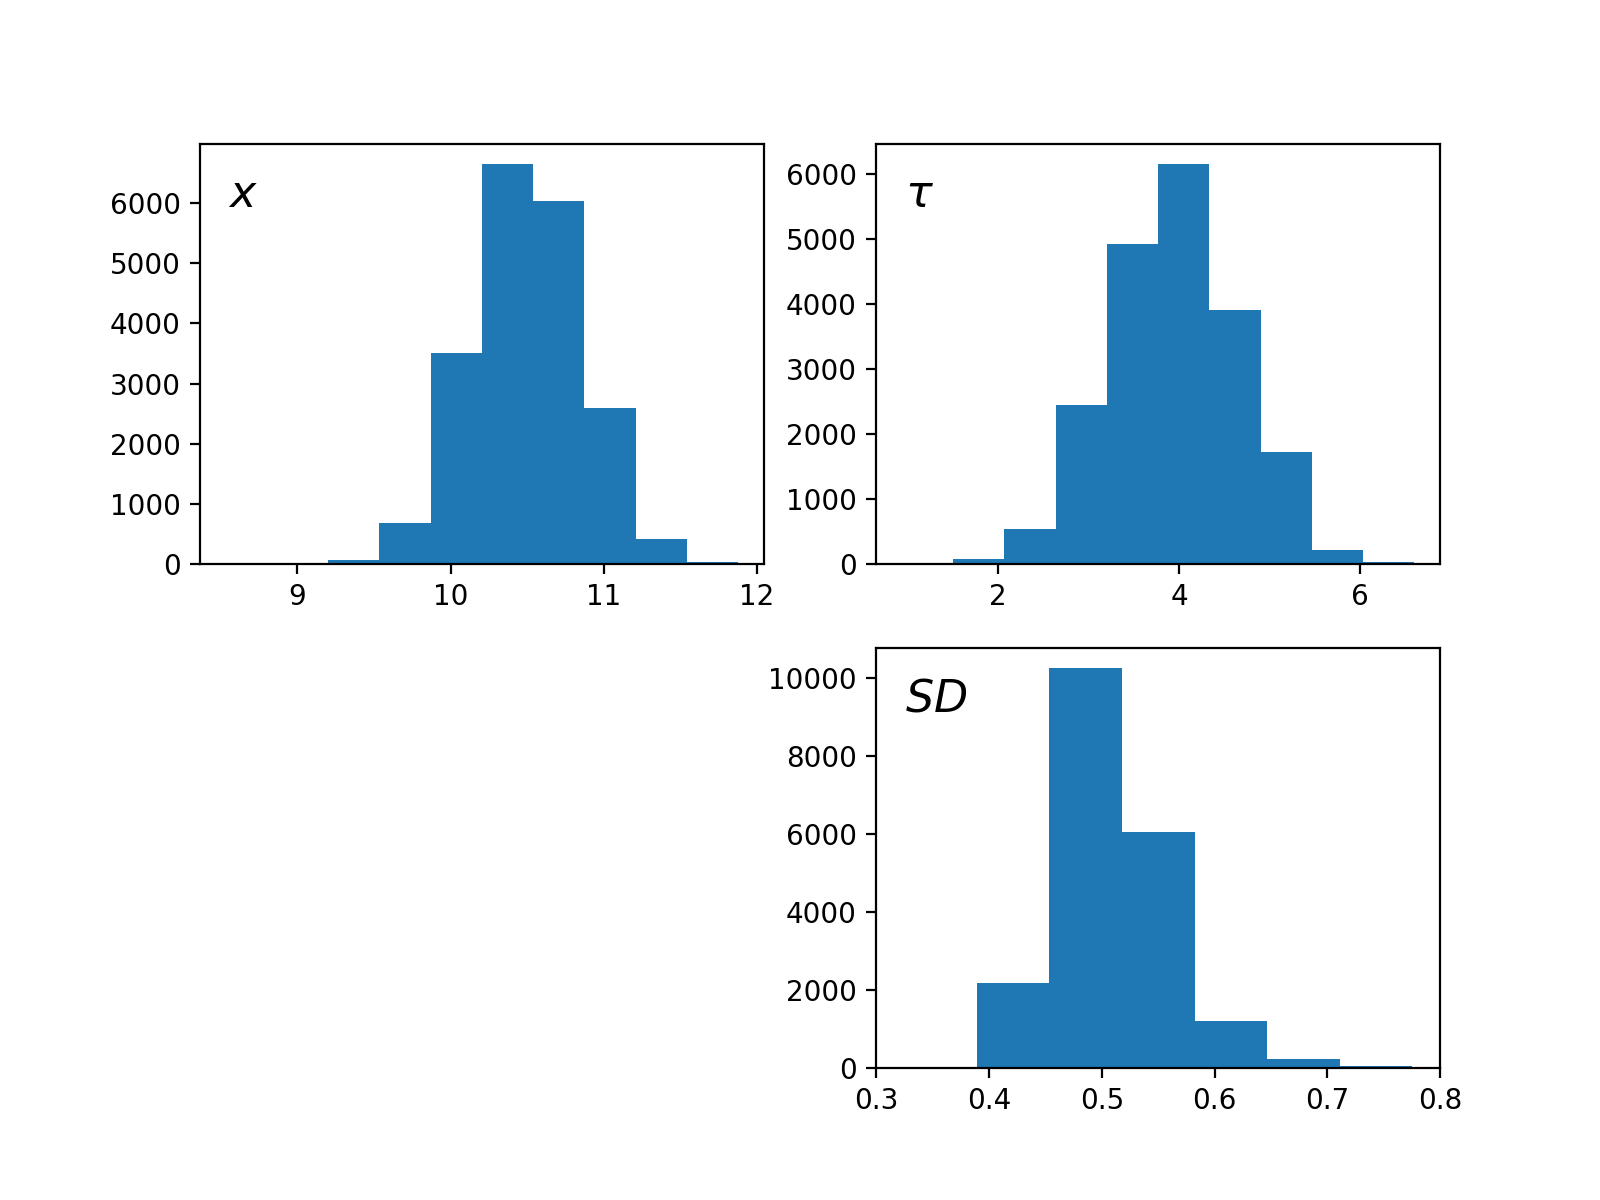

Most likely value for x: 10.49799
Most likely value for tau: 3.94621

Most likely value for sd [sd = sqrt(1/tau)]: 0.51012


In [16]:
x    = pymc.Uniform("x", -20, 20)  #prior distribution for x
tau  = pymc.Normal("tau", 4, 2, value=4)  #prior distribution for tau

@pymc.deterministic
def observations_model(x=x):
    xM1 = x + sM1  #global position of Marker 1
    xM2 = x + sM2  #global position of Marker 2
    return [xM1, xM2]
qobs = pymc.Normal("qobs", observations_model, tau, value=np.array([46,55]), observed=True)

mcmc = pymc.MCMC([qobs, x, tau])   #now tau also appears in the collection of stochastic variables
mcmc.sample(40000, 20000)

pyplot.figure(figsize=(8,6))
X   = mcmc.trace('x')[:]
TAU = mcmc.trace('tau')[:]
SD  = (1/TAU)**0.5
ax  = pyplot.subplot(221);  ax.hist(X);   ax.text(0.05, 0.85, r'$x$', size=16, transform=ax.transAxes)
ax  = pyplot.subplot(222);  ax.hist(TAU); ax.text(0.05, 0.85, r'$\tau$', size=16, transform=ax.transAxes)
ax  = pyplot.subplot(224);  ax.hist(SD);  ax.text(0.05, 0.85, r'$SD$', size=16, transform=ax.transAxes);  ax.set_xlim(0.3, 0.8)

print( 'Most likely value for x: %.5f' %X.mean() )
print( 'Most likely value for tau: %.5f' %TAU.mean() )
print()
print( 'Most likely value for sd [sd = sqrt(1/tau)]: %.5f' %SD.mean() )

Our new definition of "`tau`" implies that we are reasonably certain that the true measurement precision is 4 (sd=0.5), but it might also be slightly larger or slightly smaller.  This flexibility permits Bayesian inference to simultaneously find the most likely range of values for both $x$ and $\tau$. The final results depicted above suggest the following:

* The observed measurements tell us that the true value of $x$ is most likely very close to 10.5, but due to measurement errors we cannot be completely confident in this value.  The true value of $x$ almost certainly lies in the range [9.5, 11.5].

* The observed measurements suggest that our presumed measurement error model is probably fine, and that a value close to sd=0.5 is most likely the true error value. However, due to random measurement errors we cannot be certain. The true standard deviation of marker errors almost certainly lies in the range [0.4, 0.7].

### Summary

The mechanical slider model and marker measurements discussed in this Appendix are mechanically simple but highlight a variety of important differences between the least-squares (LS) and Bayesian approaches to inverse kinematics (IK).  While the LS approach minimizes an explicit function of the measured data, the Bayesian approach instead maximizes the maximim a posteriori probabilities (MAP) of all stochastic variables. Consequenty, the Bayesian approach propagates measurement uncertainty to the IK solution, but the LS solution does not.  The Bayesian and LS squares approaches yield equivalent IK solutions under an assumption of infinite measurement precision. Last, results above show that Bayesian IK can be sensitive to modeling assumptions, including especially to the prior distributions.